In [57]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns
import sys
sys.path.append("../")
from DSP_prototype.DSP_algorithms import stft

In [46]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Informacje o zbiorze danych "speech_commands"

## Etykiety
W zbiorze danych znajdują się pliki audio próbkowane z częstotliwością $f=16$kHz. Każdemu plikowi przypisana jest jedna z 12 dostępnych klas, które numerowane są w następujący sposób:

- 0 - down
- 1 - go
- 2 - left
- 3 - no
- 4 - off
- 5 - on
- 6 - right
- 7 - stop
- 8 - up
- 9 - yes
- 10 - silence
- 11 - unknown

In [47]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]

In [48]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

Full dataset length: 100503


In [49]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [50]:
data, labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

Filtered length: 30069


# Split into data and labels

In [51]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 21048
Validation data length: 3006
Test data length: 6015
Full dataset length: 30069


In [52]:
train_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in train_data]).astype(np.float32)
valid_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in val_data]).astype(np.float32)
test_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in test_data]).astype(np.float32)

In [53]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

In [91]:
interpreter = tf.lite.Interpreter(model_path="tra_medium_model_86test_acc_8kHz_PioterSTFT_float_float_int.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Data Type:", input_details[0]['dtype'])

Input Shape: [  1 129  61   1]
Input Data Type: <class 'numpy.float32'>


In [92]:
test_data.shape

(6015, 129, 61, 1)

In [93]:
y_pred = []
correctly = 0
for sample, y_true in zip(test_data, test_labels):
    interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(sample, 0))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class = np.argmax(output_data)
    if predicted_class == y_true:
        correctly += 1
    y_pred.append(predicted_class)
    print(f"Y_pred={predicted_class} | Y_true={y_true[0]}")

Y_pred=7 | Y_true=5
Y_pred=4 | Y_true=7
Y_pred=6 | Y_true=6
Y_pred=0 | Y_true=0
Y_pred=7 | Y_true=7
Y_pred=4 | Y_true=4
Y_pred=7 | Y_true=7
Y_pred=1 | Y_true=1
Y_pred=7 | Y_true=3
Y_pred=7 | Y_true=7
Y_pred=0 | Y_true=2
Y_pred=7 | Y_true=7
Y_pred=3 | Y_true=7
Y_pred=7 | Y_true=7
Y_pred=4 | Y_true=4
Y_pred=0 | Y_true=4
Y_pred=2 | Y_true=2
Y_pred=5 | Y_true=5
Y_pred=5 | Y_true=5
Y_pred=7 | Y_true=7
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=2
Y_pred=7 | Y_true=7
Y_pred=7 | Y_true=7
Y_pred=1 | Y_true=1
Y_pred=7 | Y_true=5
Y_pred=0 | Y_true=0
Y_pred=2 | Y_true=2
Y_pred=2 | Y_true=2
Y_pred=1 | Y_true=1
Y_pred=5 | Y_true=5
Y_pred=4 | Y_true=4
Y_pred=7 | Y_true=7
Y_pred=7 | Y_true=5
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=4 | Y_true=2
Y_pred=1 | Y_true=1
Y_pred=5 | Y_true=5
Y_pred=3 | Y_true=3
Y_pred=6 | Y_true=6
Y_pred=7 | Y_true=7
Y_pred=6 | Y_true=7
Y_pred=4 | Y_true=4
Y_pred=4 | Y_true=4
Y_pred=2 | Y_true=2
Y_pred=0 | Y_true=0
Y_pred=7 | Y_true=4
Y_pred=7 | Y_true=7
Y_pred=0 | Y_true=0


In [94]:
print(f"Accuracy: {(correctly/len(test_data))*100:.2f}%")

Accuracy: 76.96%


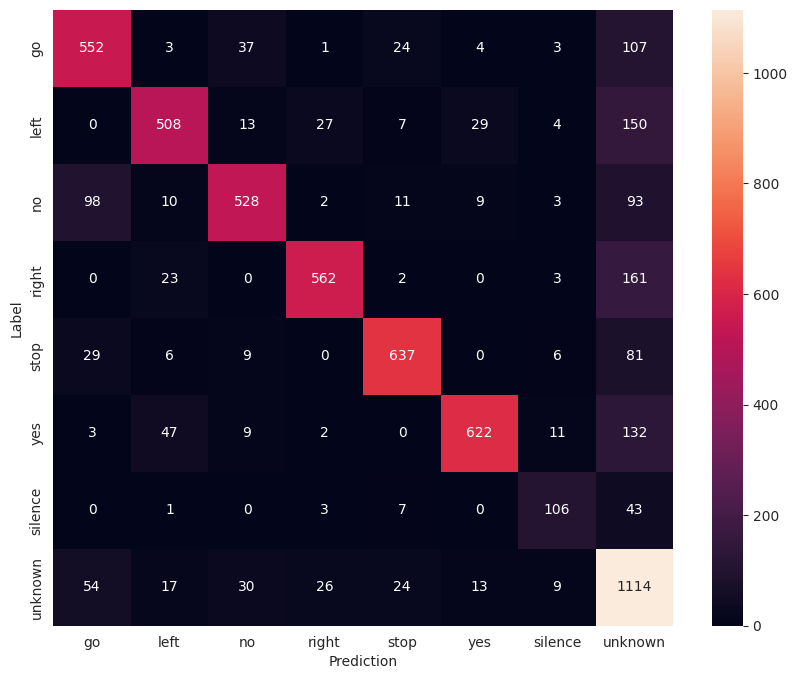

In [95]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()